In [1]:
# Common import

import os

import math
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
import h5py
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score, 
                             matthews_corrcoef, roc_curve, roc_auc_score, classification_report)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.applications import vgg16
from tensorflow.keras import backend as K

from functools import reduce # for union of more than 2 arrays
BatchNormalization
from helper_functions import *

# This is simply an alias for convenience
layers = tf.keras.layers

#Fixing seed for reproducibility
np.random.seed(42)

C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
# Loading DataSet
local_data = './DataFiles/Mg22_alphaalpha_digiSim.h5'
hf = h5py.File(local_data, 'r')

# The function load_fata (helper_functions.py) performes the operation mentioned above.
DataList, Labels = load_data(hf)
hf.close() # closing file

Dataset contains 2000 events
Data contains 5 empty events, of indexes: [384, 430, 484, 914, 1204]

Dataset contains 1995 non-empty events:
995 Beam Events, and 1000 Reaction Events



In [3]:
# Create an ordered index list : [0,1,2,...,len(DataList)]
x_idx = np.arange(len(DataList))

# Splitting in train+validation (90% in total), and test (10%)
trainval_idx, test_idx, not_used1, not_used2 = train_test_split(x_idx, x_idx, test_size = 0.10)

# Splitting the remaining part (90% of the original DataSet): Training (90%) and Validation (10%)
train_idx, val_idx, not_used3, not_used4 = train_test_split(trainval_idx, trainval_idx, test_size = 0.10)

print("Dataset was divided into:")
print(str(len(train_idx)) + " training events,")
print(str(len(val_idx)) + "  validation events, and")
print(str(len(test_idx)) + "  test events")

Dataset was divided into:
1615 training events,
180  validation events, and
200  test events


In [4]:
# Computing Features through the function calc_features (helper_functions.py)
(MeanXPerEvent, MeanYPerEvent, MeanZPerEvent, SumAPerEvent, 
PadsPerEvent, MeanWeightedXPerEvent, MeanWeightedYPerEvent, 
StDevXPerEvent, StDevYPerEvent, StDevZPerEvent,FracClosePtsPerEvent) = calc_features(DataList)

In [5]:
# Some definition before plotting 

# Splitting train_ind into beam and reaction indexes
train_r_idx = [] # List of indexes of "Reaction" training event
train_b_idx = [] # List of indexes of "Beam" training event

for i in train_idx:
    if Labels[i]>0.5:
        train_r_idx.append(i) # Indexes of "Reaction" training data
    else:
        train_b_idx.append(i) # Indexes of "Beam" training data
        
# Converting into numpy array for later use
train_r_idx = np.array(train_r_idx) 
train_b_idx = np.array(train_b_idx)

# Defining colours for histograms and scatter plot
b_color = 'black'
r_color = 'blue'

#Define legend for 2d (scatter)plots
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Beam', markerfacecolor=b_color, markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Reaction', markerfacecolor=r_color, markersize=15)]

In [6]:
xSimple = np.zeros((len(DataList),5)) # Design Matrix with 5 features

# Filling the matrix
for i in range(len(DataList)):
    xSimple[i][0] = MeanZPerEvent[i]
    xSimple[i][1] = StDevXPerEvent[i]
    xSimple[i][2] = FracClosePtsPerEvent[i]
    xSimple[i][3] = SumAPerEvent[i]
    xSimple[i][4] = PadsPerEvent[i]
# not used 
    #xSimple[i][0] = MeanXPerEvent[i]
    #xSimple[i][1] = MeanYPerEvent[i]
    #xSimple[i][1] = StDevYPerEvent[i]
    #xSimple[i][5] = StDevZPerEvent[i]

# Dividing entries in train, val and test
xSimple_train = xSimple[train_idx][:]
xSimple_val = xSimple[val_idx][:]
xSimple_test = xSimple[test_idx][:]
Labels_train = Labels[train_idx]
Labels_val = Labels[val_idx]
Labels_test = Labels[test_idx]

# Converting to DataFrame for better visualization, and for possible later use
X= pd.DataFrame(xSimple)
print("Design Matrix X:")
X.columns = ['Mean Z','stdev(X)','FCP','Total Q','Pads']
X

Design Matrix X:


,Mean Z,stdev(X),FCP,Total Q,Pads
0,961.083333,0.930198,1.000000,41292.864135,24.0
1,661.897436,5.692321,0.097436,322786.822798,195.0
2,877.083333,0.930198,1.000000,89094.206758,24.0
3,529.016129,0.646942,0.153226,168967.813590,124.0
4,938.916667,0.930198,1.000000,34598.337410,24.0
...,...,...,...,...,...
1990,485.930818,3.872534,0.062893,364154.705449,318.0
1991,817.750000,0.930198,1.000000,117215.746684,24.0
1992,526.930233,0.782013,0.418605,37851.885998,43.0
1993,940.083333,0.930198,1.000000,45542.970478,24.0


In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(xSimple_train)

# Using the standardscaler
xSimple_train_stdsc = scaler.transform(xSimple_train)
xSimple_val_stdsc = scaler.transform(xSimple_val)

# SF: Convolutional Neural Network

### How do we create an image out of an event??
This is how an event looks like: 
```
DataList[0]
```
We want to convert this in a 2D image, to use for the CNN algorithm. The first thought is to use the the (x,y) plane, and pixel the surface in ordet to save it as a 2D matrix. The logic choice would be to use the charge deposited on that pad as pixel value - we use the number of time the pad fired in that event, since it leads to better results.

**Generating the 2D matrix**: we first need how to set the grid on the x,y place. The exercise does not give us the dimension of the single pads, so we have to figure it out. This can be done in two steps:
- Extract the dimension of the x,y projection: In this way we can reconstruct the dimension of the pad plane. 
- Deduce the dimension of the single pad: We assume that in the simulation the value of x and y was assigned to be the in the center of the pad. We define our pad grid consequently. 

In [8]:
DataList[0]

array([(-2.45412970e+00,  1.45075214, 834., 417, 6.73360577e+03, 0),
       (-1.33514404e-05,  2.79990482, 834., 417, 1.25854633e+04, 0),
       (-2.45412970e+00, -1.45075214, 834., 417, 1.70520808e+03, 0),
       ( 2.45413303e+00, -1.45075214, 900., 450, 3.77884522e+03, 0),
       (-1.33514404e-05, -2.79990482, 900., 450, 1.13686783e+04, 0),
       ( 2.45413303e+00,  1.45075214, 962., 481, 3.21076480e+03, 0),
       ( 4.90825081e+00, -5.70140886, 964., 482, 4.45706507e+01, 0),
       ( 2.45410442e+00,  7.05056143, 966., 483, 2.11128009e+01, 0),
       (-2.45413113e+00, -7.05056143, 984., 492, 1.90553867e+01, 0),
       (-4.90824747e+00,  5.70140886, 986., 493, 1.97473273e+01, 0),
       ( 4.90825081e+00,  5.70140886, 986., 493, 2.12675051e+01, 0),
       (-4.90824747e+00,  2.79990482, 990., 495, 4.76823698e+01, 0),
       (-4.90824747e+00, -5.70140886, 990., 495, 2.12226325e+01, 0),
       (-4.90824747e+00, -2.79990482, 990., 495, 2.63826991e+02, 0),
       ( 4.90825081e+00,  2.799904

#### Step 1 : Get Pad Plane Dimenstion.
We can easily extract the dimension of the image we want to create, based on the max/min values of the (x,y)-tuple

In [28]:
# Generate arrays to perform math operations
prepare_data()
x_max = np.amax(xy_values)
x_min = np.amin(xy_values)
    
y_max = np.amax(yy_values)
y_min = np.amin(yy_values)

print("PAD PLANE Dimensions: ")
print("-----------------------------------------------------")
print("Max x: ", round(x_max,2)  ," and Min x: ",  round(x_min,2) )
print("Max y: ", round(y_max,2)  ," and Min y: ",  round(y_min,2) )
print("")
    
x_uniques = np.unique(np.around(x_values,3))
y_uniques = np.unique(np.around(y_values,3))
    
print("Possible positive values of x: ")
print(x_uniques[x_uniques>0][0:10], " and so on...")
print("Possible positive values of y: ")
print(y_uniques[y_uniques>0][0:10], " and so on...")
print("")
x_diff = np.diff(x_uniques)
y_diff = np.diff(y_uniques)
    


NameError: name 'y_values' is not defined

In [9]:
points = prepare_points(DataList)

    

PAD PLANE Dimensions: 
-----------------------------------------------------
Max x:  255.23  and Min x:  -255.23
Max y:  252.37  and Min y:  -252.37

Possible positive values of x: 
[ 2.454  4.908  7.362  9.816 12.271 14.725 17.179 19.633 22.087 24.541]  and so on...
Possible positive values of y: 
[ 1.451  2.8    2.868  5.701  5.837  7.051  9.952 11.301 11.369 14.203]  and so on...



In order to calculate the cell spacing it is better to plot the values on a graph, and do it manually. We would fail doing it automatically, both because we need a clever way to split the image, and because of rounding errors.

TypeError: scatter() missing 1 required positional argument: 'y'

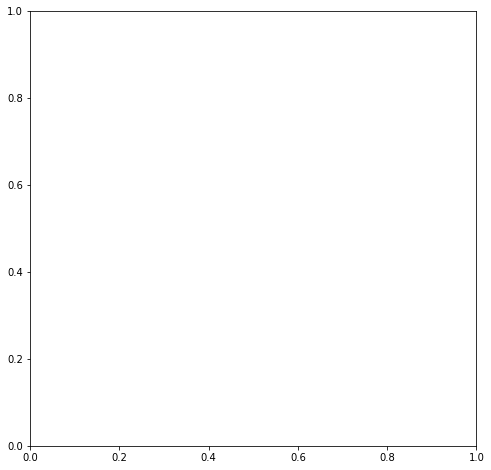

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(points, c = "black", alpha=0.8)
ax.set_title("Sum of All Events")
ax.set_xlabel("X")
ax.set_ylabel("Y")
    
ax.set_xticks(np.arange(-10, +10, 1))
ax.set_yticks(np.arange(-10, +10, 1))

ax.set_xlim(-10,+10)
ax.set_ylim(-10,+10) # I want to maintan plot symmetric

plt.grid(color='gray', linestyle='-', linewidth=1)
    
fig.tight_layout()
plt.show()

#### Step 2 : Get Single Pad Dimenstion.
First, we plot the superposition of all the projection acquired event by event, in this way the pad structure should become visible. 

We expect x,y to assume discrete value, and we can extract the increase step. In principle the x and y step may be different (rectangular pads, exagonal, or other shapes), and also the step may differ from region to region. 

For this exercise purporse, after calculating the step close to the center, we just use the same step along all the pad plane direction, and assume squared pads.

Here we get a clear idea of the pad plane structure, their shape, and the spacing between every single pad.
using a proper grid to pixel the image.

In [10]:
# Manually extracting values
x_spc = 2.45411777
x_shift = x_spc/2
y_spc = 2.1422616225
y_shift = 0

Grid Parameters:
----------------------------------
Pixeling over x-direction:
X grid spacing:  2.45411777
First x cell limits:  (1.227058885, 3.681176655)
Number of pixel on x direction: 105*2 =  210
Pixeling over y-direction:
X grid spacing:  2.1422616225
First y cell limits:  (0, 2.1422616225)
Number of pixel in y direction: 118*2 =  236
Showing the Pixel Grid


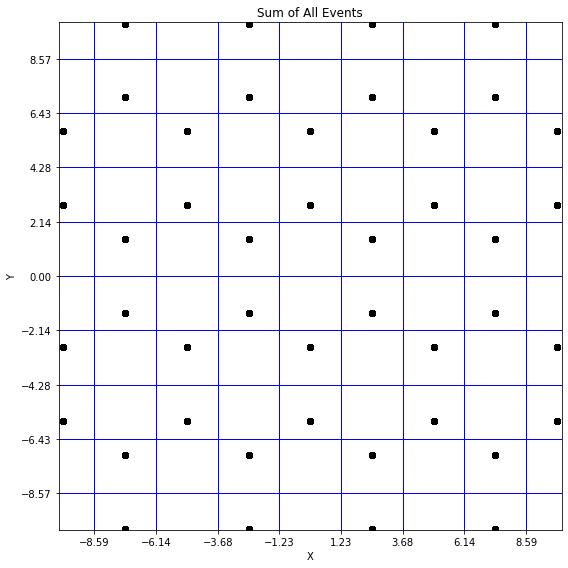

In [11]:
# Show the grid
show_grid(points, x_lim, y_lim, x_spc, y_spc, x_shift, y_shift)

### Alternative Grid trial
We do not like that many pads will have for sure no charge, since they do not contain any points. We try to fuse four pads together, and use the new grid as show below.

Grid Parameters:
----------------------------------
Pixeling over x-direction:
X grid spacing:  4.90823554
First x cell limits:  (1.227058885, 6.135294425)
Number of pixel on x direction: 53*2 =  106
Pixeling over y-direction:
X grid spacing:  4.284523245
First y cell limits:  (0, 4.284523245)
Number of pixel in y direction: 59*2 =  118
Showing the Pixel Grid


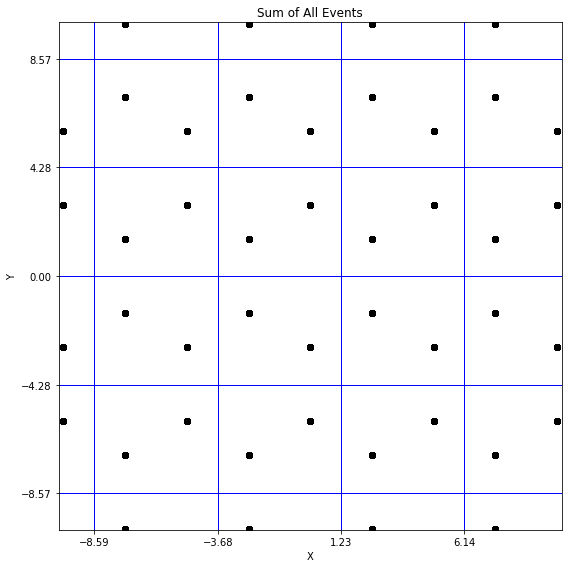

In [12]:
# The new grid ("ag" stand for alternative grid)
x_spc_ag = x_spc*2
y_spc_ag = y_spc*2
x_shift_ag = x_spc_ag/4
y_shift_ag = 0

show_grid(points, x_lim, y_lim, x_spc_ag, y_spc_ag, x_shift_ag, y_shift_ag)

### Transalte an event into an image
We save two different type of images:
- images_Q: pixel value is equal to charge deposited.
- images: pixel value is the number of time that pixel fired during the event.

In [13]:
# 1st inxes Event, 2nd y, 3rd x

Q = []
pads = []

for i in range(len(points)): # loop on event number
    Q.append([])
    pads.append([])
    for j in range(len(points[i])): # loop on event rows
        Q[i].append(DataList[i][j][2]) 
        pads[i].append(1)


images = generate_images(points, Q ,x_lim, y_lim, x_spc_ag, y_spc_ag, x_shift_ag, y_shift_ag)
images_1 = generate_images(points, pads,  x_lim, y_lim, x_spc_ag, y_spc_ag, x_shift_ag, y_shift_ag)

The images are now created on a grid 236x209 and normalized form (0,255)

### Reducing Images Dimenstion
We want to reduce the dimension to limit the time to run the model. Also most of the information is contained in the center of the pad plane. 

In [14]:
# Working with reduced images

images_r = reduce_images_dim(images, 60)
images_r_1 = reduce_images_dim(images_1, 60)


In [15]:
images_f = fuse_pixels(images_r_1, 2,2)    
    

30 30
(1995, 30, 30)


In [16]:
# Normalize the data (0-255)
images_rn= normalize_image_data(images_r)
images_rn_1= normalize_image_data(images_r_1)
images_f_1= normalize_image_data(images_f)
images_n= normalize_image_data(images)


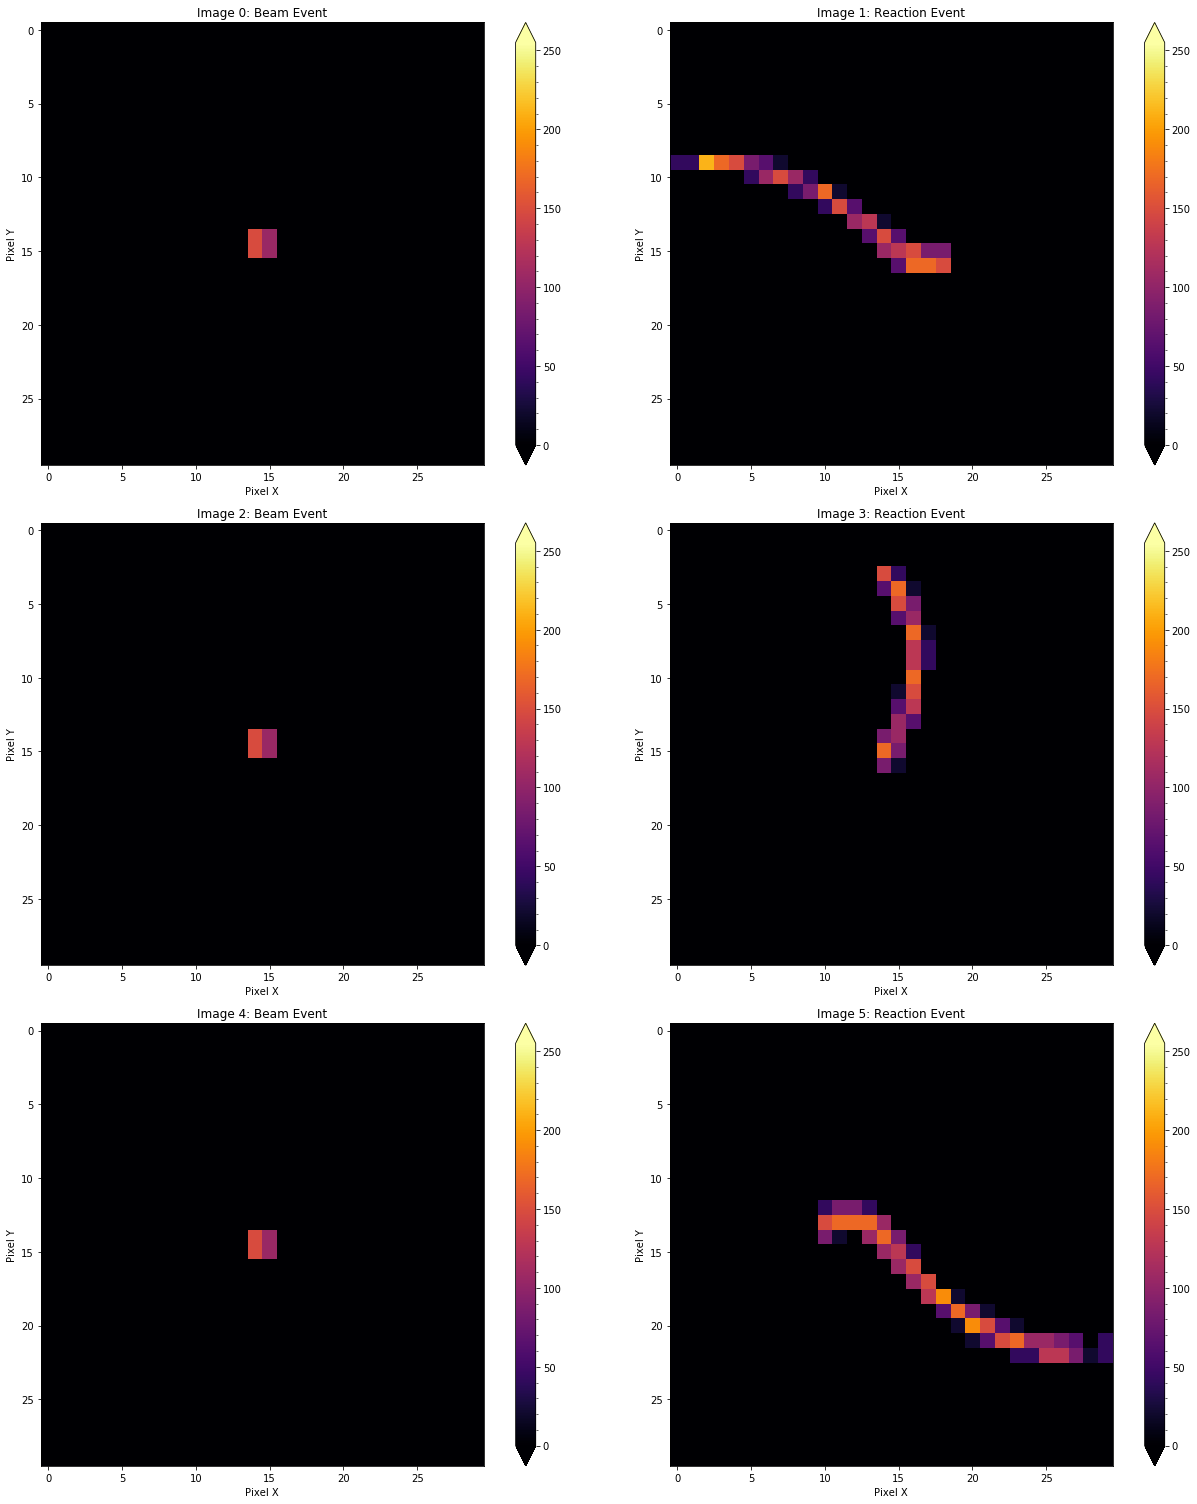

In [17]:
# Plot some Images


plot_images(images_f_1, Labels)

In order to distinguish between beam - reaction the first choice (images) looks better.

### Convolutional Network

In [18]:
from keras.utils import to_categorical

images = np.reshape(images_reduced, (images_reduced.shape[0], 30, 40, 1)) # image, x, y, ch
images_Q = np.reshape(images_reduced, (images_reduced.shape[0], 40, 40, 1)) # image, x, y, ch

images_train, images_val, labels_train, labels_val = train_test_split(images_Q, Labels)
label2_train = to_categorical(labels_train)
label2_val = to_categorical(labels_val)

print(images.shape)
print("")
print(images_train.shape)
print(images_val.shape)





Using TensorFlow backend.


NameError: name 'images_reduced' is not defined

### Setting the model

In [ ]:
my_model = tf.keras.Sequential()

my_model.add(tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=(10, 10),
        activation='relu',
        padding='same',
        input_shape=images.shape[1:] # Shape of a single imag
                                )
        )

my_model.add(BatchNormalization())

my_model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
my_model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'))
my_model.add(tf.keras.layers.Flatten())
my_model.add(tf.keras.layers.Dense(40, activation='relu'))
my_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Once the model is defined, we need to compile it. 
# This is where we specify the loss function, optimizer, and metrics if we want.
my_model.compile(
    tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.8, beta_2=0.9),
    loss='binary_crossentropy', #'sparse_categorical_crossentropy',
    metrics=['accuracy']
)
my_model.summary()

In [ ]:
history = my_model.fit(images_train,
          labels_train,
          batch_size=128,
          epochs=5,
          validation_data=(images_val, labels_val));

In [ ]:
make_nn_plots(history,0.95)

In [ ]:
CNN_pred_train_pre = my_model.predict(images_train)
CNN_pred_val_pre = my_model.predict(images_val)
CNN_pred_train = CNN_pred_train_pre > 0.5
CNN_pred_val = CNN_pred_val_pre > 0.5
print_model_performance(labels_train, CNN_pred_train, "Training")
print_model_performance(labels_val, CNN_pred_val, "Validation")

### Using VGG model

In [ ]:
images_3d = np.expand_dims(images_reduced,3)
images_3d = np.repeat(images_3d,3,3)

images_3d.shape


In [ ]:
# Split the data into training and validation sets
images_train, images_val, labels_train, labels_val = train_test_split(images_3d, Labels)

model = build_pretrained_vgg_model((dim,dim,3), 2)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_vgg = model.fit(images_train,
          labels_train,
          batch_size=32,
          epochs=5,
          validation_data=(images_val, labels_val));

In [ ]:
make_nn_plots(history_vgg,0.95)

In [ ]:
VGG_pred_train_pre = model.predict(images_train)
VGG_pred_val_pre = model.predict(images_val)
VGG_pred_train = VGG_pred_train_pre > 0.5
VGG_pred_val = VGG_pred_val_pre > 0.5
print(VGG_pred_train)
print_model_performance(labels_train, VGG_pred_train, "Training")
print_model_performance(labels_val, VGG_pred_val, "Validation")